In [1]:
!pip install pandasql
!pip install geopandas
import pandas as pd
import pandasql as ps
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime as dt
import requests
from lxml import html

from google.colab import drive
drive.mount("/content/gdrive")

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=c3ce27921aa1c371729ce43e17d1fe6ecdf35fad503bf3e6a5e5d80325b2b4dc
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
     |████████████████████████████████| 1.0 MB 11.6 MB/s 
     |████████████████████████████████| 6.3 MB 24.7 MB/s 
     |████████████████████████████████| 15.4 MB 25.1 MB/s 
Mounted at /content/gdrive


In [2]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [3]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('545-final-project').getOrCreate()


In [5]:
%load_ext sparkmagic.magics

In [6]:
import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [20]:
president_county_2016_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/20161108__us__general__president__county.csv')
counties_sdf = spark.read.csv('/content/gdrive/My Drive/CIS545Final/US_counties_COVID19_health_weather_data.csv', header=True)
state_abbrv_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/state_to_abbrv.csv')

In [21]:
 ps.sqldf('''SELECT * FROM president_county_2016_df WHERE state="WI" ORDER BY votes desc''')

,state,county,office,district,party,candidate,votes
0,WI,Totals,President,None,None,Total,2976150.0
1,WI,Totals,President,None,REP,Donald J. Trump,1405284.0
2,WI,Totals,President,None,DEM,Hillary Clinton,1382536.0
3,WI,MILWAUKEE,President,None,None,Total,441053.0
4,WI,DANE,President,None,None,Total,309354.0
...,...,...,...,...,...,...,...
1309,WI,RACINE,President,None,None,Scattering,0.0
1310,WI,SAUK,President,None,None,Scattering,0.0
1311,WI,SHAWANO,President,None,None,Scattering,0.0
1312,WI,WASHINGTON,President,None,None,Scattering,0.0


**Data Cleaning**

In [22]:
president_county_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46159 entries, 0 to 46158
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      46159 non-null  object 
 1   county     46111 non-null  object 
 2   office     46159 non-null  object 
 3   district   0 non-null      float64
 4   party      29546 non-null  object 
 5   candidate  46159 non-null  object 
 6   votes      45947 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.5+ MB


In [ ]:
counties_sdf.printSchema()

In [11]:
#drop the office column since the only value is president
#drop district column since all values are null
president_county_2016_df = ps.sqldf("SELECT state, county, party, candidate, votes FROM president_county_2016_df WHERE `party` IS NOT NULL;", globals())
winner_county_df = ps.sqldf("SELECT *, MAX(votes) FROM president_county_2016_df GROUP BY `state`, `county` ORDER BY `party`", globals())
nonnull_parties_df = ps.sqldf("SELECT `party` FROM winner_county_df GROUP BY `party`", globals())
states = ps.sqldf("SELECT `state` FROM winner_county_df GROUP BY `state`", globals()) 

**Standardize party values**

In [27]:
winner_county_df = ps.sqldf('''SELECT *, 
CASE
      WHEN party = "D" THEN "D"
      WHEN party = "DEM" THEN "D"
      WHEN party = "DFL" THEN "D"
      WHEN party = "Democrat" THEN "D"
      WHEN party = "Democratic" THEN "D"
      WHEN party = "Democratic Party" THEN "D"
      WHEN party = "Green" THEN "G"
      WHEN party = "LIB" THEN "L"
      WHEN party = "Libertarian" THEN "L"
      WHEN party = "R" THEN "R"
      WHEN party = "REP" THEN "R"
      WHEN party = "Republican" THEN "R"
      WHEN party = "Republican Party" THEN "R"
      ELSE NULL
END
as stand_party
FROM winner_county_df''', globals())
winner_county_df = ps.sqldf('''SELECT *, 
CASE
      WHEN stand_party = "D" THEN 0
      WHEN stand_party = "G" THEN .5
      WHEN stand_party = "L" THEN .5
      WHEN stand_party = "R" THEN 1
      ELSE NULL
END as party_label FROM winner_county_df''', globals())
winner_county_df['county'] = winner_county_df['county'].str.title()
winner_county_df['county'] = winner_county_df['county'].str.strip()
winner_county_df['state'] = winner_county_df['state'].str.strip()
winner_county_df['county'] = winner_county_df['county'].apply(lambda x: ((str) (x)).replace(' County', ''))
winner_county_df

,state,county,party,candidate,votes,MAX(votes),stand_party,party_label,party_label
0,AL,Bullock,D,Hillary Clinton,3530.0,3530.0,D,0.0,0.0
1,AL,Dallas,D,Hillary Clinton,12836.0,12836.0,D,0.0,0.0
2,AL,Greene,D,Hillary Clinton,4013.0,4013.0,D,0.0,0.0
3,AL,Hale,D,Hillary Clinton,4775.0,4775.0,D,0.0,0.0
4,AL,Jefferson,D,Hillary Clinton,156873.0,156873.0,D,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4732,CO,Sedgwick,Republican Party,Donald J. Trump,1015.0,1015.0,R,1.0,1.0
4733,CO,Teller,Republican Party,Donald J. Trump,9745.0,9745.0,R,1.0,1.0
4734,CO,Washington,Republican Party,Donald J. Trump,2299.0,2299.0,R,1.0,1.0
4735,CO,Weld,Republican Party,Donald J. Trump,76651.0,76651.0,R,1.0,1.0


In [28]:
ps.sqldf('''SELECT * FROM winner_county_df WHERE state="VA"''', globals())

,state,county,party,candidate,votes,MAX(votes),stand_party,party_label
0,VA,Albemarle,DEM,Hillary Clinton,33345.0,33345.0,D,0.0
1,VA,Alexandria City,DEM,Hillary Clinton,57242.0,57242.0,D,0.0
2,VA,Arlington,DEM,Hillary Clinton,92016.0,92016.0,D,0.0
3,VA,Brunswick,DEM,Hillary Clinton,4481.0,4481.0,D,0.0
4,VA,Charles City,DEM,Hillary Clinton,2496.0,2496.0,D,0.0
...,...,...,...,...,...,...,...,...
129,VA,Waynesboro City,REP,Donald J. Trump,4801.0,4801.0,R,1.0
130,VA,Westmoreland,REP,Donald J. Trump,4448.0,4448.0,R,1.0
131,VA,Wise,REP,Donald J. Trump,12086.0,12086.0,R,1.0
132,VA,Wythe,REP,Donald J. Trump,10046.0,10046.0,R,1.0


**Geographical visualization**

In [14]:
counties_sdf.createOrReplaceTempView('counties')

In [ ]:
counties_sdf = spark.sql("SELECT county, state, AVG(lat) as lat, AVG(lon) as lon FROM counties GROUP BY county, state ORDER BY county, state")
counties_sdf.show()
counties_df = counties_sdf.toPandas()
counties_df

In [ ]:
state_abbrv_df

In [ ]:
counties_df = ps.sqldf("SELECT A.county,	A.state, B.code, A.lat, A.lon FROM counties_df A JOIN state_abbrv_df B ON A.state = B.state ORDER BY A.state, A.county", globals())
counties_df['county'] =  counties_df['county'].str.title()
counties_df['county'] =  counties_df['county'].str.strip()
counties_df['Code'] =  counties_df['Code'].str.strip()
counties_df

In [35]:
ps.sqldf('''SELECT * FROM counties_df group by Code''', globals())

,county,state,Code,lat,lon
0,Yukon-Koyukuk Census Area,Alaska,AK,65.508733,-151.391543
1,Winston,Alabama,AL,34.149204,-87.373669
2,Yell,Arkansas,AR,35.002610,-93.411246
3,Yuma,Arizona,AZ,32.769430,-113.905597
4,Yuba,California,CA,39.269014,-121.351276
5,Yuma,Colorado,CO,40.002943,-102.424258
6,Windham,Connecticut,CT,41.830029,-71.987453
7,District Of Columbia,District of Columbia,DC,38.904742,-77.016296
8,Sussex,Delaware,DE,38.660560,-75.390040
9,Washington,Florida,FL,30.610607,-85.665337


In [29]:
winner_county_joined_df = ps.sqldf("SELECT B.state, B.Code, A.county, B.lat, B.lon, A.candidate, A.votes, A.stand_party, A.party_label FROM winner_county_df A JOIN counties_df B ON (A.state = B.Code AND A.county = B.county)", globals())
#winner_county_df = ps.sqldf("SELECT * FROM winner_county_df A JOIN counties_df B ON (A.state = B.Code AND A.county = B.county) WHERE A.state = 'WI'", globals())
#wi_join = ps.sqldf("SELECT * FROM Wi_election A JOIN wi_counties B ON (A.state = B.Code AND A.county = B.county)", globals())

In [30]:
winner_county_joined_df

,state,Code,county,lat,lon,candidate,votes,stand_party,party_label
0,Alabama,AL,Bullock,32.100534,-85.715686,Hillary Clinton,3530.0,D,0.0
1,Alabama,AL,Dallas,32.325976,-87.106472,Hillary Clinton,12836.0,D,0.0
2,Alabama,AL,Greene,32.853157,-87.952213,Hillary Clinton,4013.0,D,0.0
3,Alabama,AL,Hale,32.762670,-87.629151,Hillary Clinton,4775.0,D,0.0
4,Alabama,AL,Jefferson,33.554320,-86.896496,Hillary Clinton,156873.0,D,0.0
...,...,...,...,...,...,...,...,...,...
3077,Colorado,CO,Sedgwick,40.875923,-102.351833,Donald J. Trump,1015.0,R,1.0
3078,Colorado,CO,Teller,38.882158,-105.161794,Donald J. Trump,9745.0,R,1.0
3079,Colorado,CO,Washington,39.971023,-103.201257,Donald J. Trump,2299.0,R,1.0
3080,Colorado,CO,Weld,40.554862,-104.392458,Donald J. Trump,76651.0,R,1.0


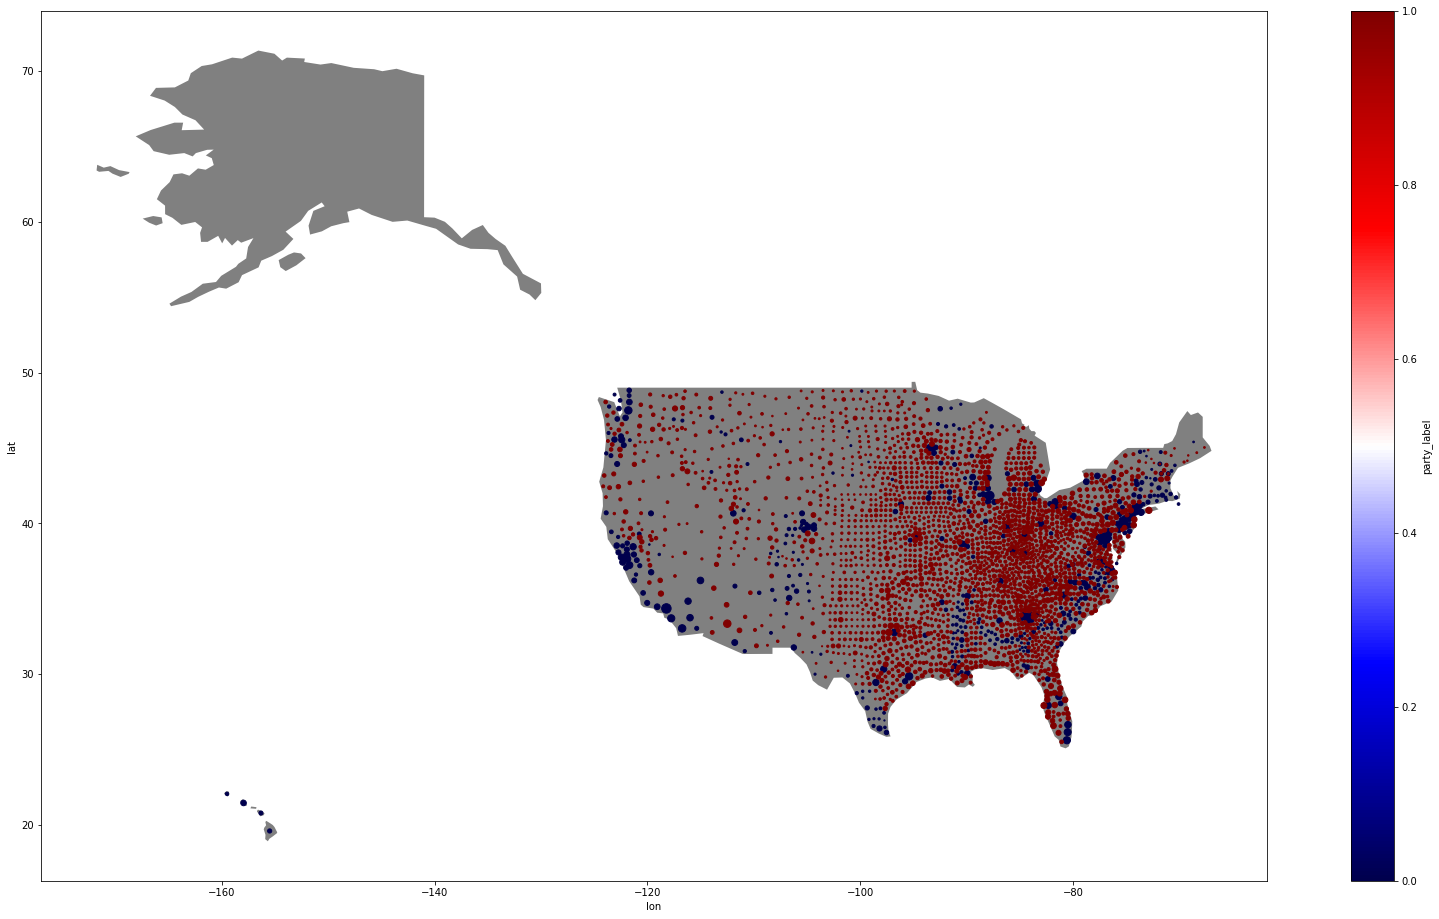

In [32]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
base = countries[countries["name"] == "United States of America"].plot(color="gray")
# winner_county_df.plot(x="lon", y="lat", kind="scatter", c="brightness",
#         colormap="YlOrRd")
v = winner_county_joined_df['votes']
#winner_county_df.plot(figsize=(30,16), ax = base, x="lon", y="lat", kind="scatter", marker='o', c="party_label", colormap="seismic", markersize = (v**2)*5)
winner_county_joined_df.plot(figsize=(30,16), ax = base, x="lon", y="lat", kind="scatter", marker='.', c="party_label", cmap="seismic", s = v**.4)
